batch_size: 16, D_in: 784, D_out: 10
0.0% iter: 0, loss: 65.70173344720521
0.4% iter: 100, loss: 1.7669960614140017
0.8% iter: 200, loss: 1.0605070370168939
1.2% iter: 300, loss: 0.01729965486588264
1.6% iter: 400, loss: 0.8752996788472084
2.0% iter: 500, loss: 0.7817323066419919
2.4% iter: 600, loss: 0.9634838647696466
2.8% iter: 700, loss: 1.1647728310602563
3.2% iter: 800, loss: 0.35571547859895
3.6% iter: 900, loss: 0.1813339645032253
4.0% iter: 1000, loss: 0.7835528939650417
4.4% iter: 1100, loss: 0.13491676229329608
4.8% iter: 1200, loss: 0.08052703188757149
5.2% iter: 1300, loss: 0.23038029962953505
5.6% iter: 1400, loss: 1.2017202361915773
6.0% iter: 1500, loss: 0.3096639889766301
6.4% iter: 1600, loss: 0.29091684926625305
6.8% iter: 1700, loss: 0.17144400625759315
7.2% iter: 1800, loss: 0.15607330031091907
7.6% iter: 1900, loss: 0.2663921978354015
8.0% iter: 2000, loss: 0.28952387722220096
8.4% iter: 2100, loss: 0.5259469996750105
8.8% iter: 2200, loss: 0.33846417336988854
9.2

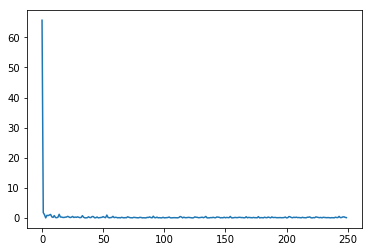

In [22]:
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from abc import ABCMeta, abstractmethod

filename = [
	["training_images","train-images-idx3-ubyte.gz"],
	["test_images","t10k-images-idx3-ubyte.gz"],
	["training_labels","train-labels-idx1-ubyte.gz"],
	["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

def draw_losses(losses):
    t = np.arange(len(losses))
    plt.plot(t, losses)
    plt.show()

def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

class FC():
    """
    Fully connected layer
    """
    def __init__(self, D_in, D_out):
        #print("Build FC")
        self.cache = None
        #self.W = {'val': np.random.randn(D_in, D_out), 'grad': 0}
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        #print("FC: _forward")
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        #print("FC: _backward")
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        #self._update_params()
        return dX

    def _update_params(self, lr=0.001):
        # Update the parameters
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

class ReLU():
    """
    ReLU activation layer
    """
    def __init__(self):
        #print("Build ReLU")
        self.cache = None

    def _forward(self, X):
        #print("ReLU: _forward")
        out = np.maximum(0, X)
        self.cache = X
        return out

    def _backward(self, dout):
        #print("ReLU: _backward")
        X = self.cache
        dX = np.array(dout, copy=True)
        dX[X <= 0] = 0
        return dX

class Sigmoid():
    """
    Sigmoid activation layer
    """
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        self.cache = X
        return 1 / (1 + np.exp(-X))

    def _backward(self, dout):
        X = self.cache
        dX = dout*X*(1-X)
        return dX

class tanh():
    """
    tanh activation layer
    """
    def __init__(self):
        self.cache = X

    def _forward(self, X):
        self.cache = X
        return np.tanh(X)

    def _backward(self, X):
        X = self.cache
        dX = dout*(1 - np.tanh(X)**2)
        return dX

class Softmax():
    """
    Softmax activation layer
    """
    def __init__(self):
        #print("Build Softmax")
        self.cache = None

    def _forward(self, X):
        #print("Softmax: _forward")
        maxes = np.amax(X, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(X - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (X, Y, Z)
        return Z # distribution

    def _backward(self, dout):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(dout,dZ)
        dX = np.dot(dX,dY)
        return dX

class Dropout():
    """
    Dropout layer
    """
    def __init__(self, p=1):
        self.cache = None
        self.p = p

    def _forward(self, X):
        M = (np.random.rand(*X.shape) < self.p) / self.p
        self.cache = X, M
        return X*M

    def _backward(self, dout):
        X, M = self.cache
        dX = dout*M/self.p
        return dX

class Conv():
    """
    Conv layer
    """
    def __init__(self, Cin, Cout, F, stride=1, padding=0, bias=True):
        self.Cin = Cin
        self.Cout = Cout
        self.F = F
        self.S = stride
        #self.W = {'val': np.random.randn(Cout, Cin, F, F), 'grad': 0}
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.cache = None
        self.pad = padding

    def _forward(self, X):
#         X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        Y = np.zeros((N, self.Cout, H_, W_))

        for n in range(N):
            for c in range(self.Cout):
                for h in range(H_):
                    for w in range(W_):
                        Y[n, c, h, w] = np.sum(X[n, :, h:h+self.F, w:w+self.F] * self.W['val'][c, :, :, :]) + self.b['val'][c]

        self.cache = X
        return Y

    def _backward(self, dout):
        # dout (N,Cout,H_,W_)
        # W (Cout, Cin, F, F)
        X = self.cache
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        W_rot = np.rot90(np.rot90(self.W['val']))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.W['val'].shape)
        db = np.zeros(self.b['val'].shape)

        # dW
        for co in range(self.Cout):
            for ci in range(Cin):
                for h in range(self.F):
                    for w in range(self.F):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])

        # db
        for co in range(self.Cout):
            db[co] = np.sum(dout[:,co,:,:])

        dout_pad = np.pad(dout, ((0,0),(0,0),(self.F,self.F),(self.F,self.F)), 'constant')
        #print("dout_pad.shape: " + str(dout_pad.shape))
        # dX
        for n in range(N):
            for ci in range(Cin):
                for h in range(H):
                    for w in range(W):
                        #print("self.F.shape: %s", self.F)
                        #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
                        dX[n, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[n, :, h:h+self.F,w:w+self.F])

        return dX

class MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def _forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
        for n in range(N):
            for cin in range(Cin):
                for w_ in range(W_):
                    for h_ in range(H_):
                        Y[n,cin,w_,h_] = np.max(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
                        i,j = np.unravel_index(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].argmax(), (F,F))
                        M[n,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        for n in range(N):
            for c in range(Cin):
                #print("(n,c): (%s,%s)" % (n,c))
                dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)
        return dX*M

def NLLLoss(Y_pred, Y_true):
    """
    Negative log likelihood loss
    """
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N

class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax._forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class SoftmaxLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        loss = NLLLoss(Y_pred, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = Y_pred.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class Net(metaclass=ABCMeta):
    # Neural network super class

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, X):
        pass

    @abstractmethod
    def backward(self, dout):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def set_params(self, params):
        pass


class TwoLayerNet(Net):

    #Simple 2 layer NN

    def __init__(self, N, D_in, H, D_out, weights=''):
        self.FC1 = FC(D_in, H)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        return h2

    def backward(self, dout):
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b] = params


class ThreeLayerNet(Net):

    #Simple 3 layer NN

    def __init__(self, N, D_in, H1, H2, D_out, weights=''):
        self.FC1 = FC(D_in, H1)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H1, H2)
        self.ReLU2 = ReLU()
        self.FC3 = FC(H2, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        a2 = self.ReLU2._forward(h2)
        h3 = self.FC3._forward(a2)
        return h3

    def backward(self, dout):
        dout = self.FC3._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params


class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(1, 6, 5)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool(2,2)
        self.conv2 = Conv(6, 16, 5)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool(2,2)
        self.FC1 = FC(16*4*4, 120)
        self.ReLU3 = ReLU()
        self.FC2 = FC(120, 84)
        self.ReLU4 = ReLU()
        self.FC3 = FC(84, 10)
        self.Softmax = Softmax()

        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.ReLU1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.ReLU2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.ReLU3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.ReLU4._forward(h4)
        h5 = self.FC3._forward(a5)
        # a5 = self.Softmax._forward(h5)
        return h5

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.ReLU4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])

class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])


"""
(1) Prepare Data: Load, Shuffle, Normalization, Batching, Preprocessing
"""

#mnist.init()
X_train, Y_train, X_test, Y_test = load()
X_train, X_test = X_train/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)

batch_size = 16
D_in = 784
D_out = 10

print("batch_size: " + str(batch_size) + ", D_in: " + str(D_in) + ", D_out: " + str(D_out))

### TWO LAYER NET FORWARD TEST ###
#H=400
#model = nn.TwoLayerNet(batch_size, D_in, H, D_out)
H1=300
H2=100
# model = ThreeLayerNet(batch_size, D_in, H1, H2, D_out)
model = LeNet5()


losses = []
#optim = optimizer.SGD(model.get_params(), lr=0.0001, reg=0)
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
criterion = CrossEntropyLoss()

# TRAIN
ITER = 25000
for i in range(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
    Y_batch = MakeOneHot(Y_batch, D_out)

    # forward, loss, backward, step
    X_batch = X_batch.reshape(batch_size,1,28,28)
    Y_pred = model.forward(X_batch)
    loss, dout = criterion.get(Y_pred, Y_batch)
    model.backward(dout)
    optim.step()

    if i % 100 == 0:
        print("%s%% iter: %s, loss: %s" % (100*i/ITER,i, loss))
        losses.append(loss)


# save params
weights = model.get_params()
with open("weights.pkl","wb") as f:
	pickle.dump(weights, f)

draw_losses(losses)

In [25]:
# TRAIN SET ACC
X_train = X_train.reshape(len(X_train),1,28,28)
Y_pred = model.forward(X_train)
result = np.argmax(Y_pred, axis=1) - Y_train
result = list(result)
print("TRAIN--> Correct: " + str(result.count(0)) + " out of " + str(X_train.shape[0]) + ", acc=" + str(result.count(0)/X_train.shape[0]))

TRAIN--> Correct: 57381 out of 60000, acc=0.95635


In [23]:
# TEST SET ACC
X_test = X_test.reshape(len(X_test),1,28,28)
Y_pred = model.forward(X_test)
result = np.argmax(Y_pred, axis=1) - Y_test
result = list(result)

In [24]:
print("TEST--> Correct: " + str(result.count(0)) + " out of " + str(X_test.shape[0]) + ", acc=" + str(result.count(0)/X_test.shape[0]))

TEST--> Correct: 9588 out of 10000, acc=0.9588
